In [8]:
import scanpy as sc
import os 

from omegaconf import OmegaConf as om
from mosaicfm.utils.util import compute_lisi_scores
from inference.predict_embeddings import predict_embeddings

In [ ]:
# Define Config 
cfg = {
  "paths": {
    "model_dir": "/tahoe/data/ckpts/TahoeX1/mosaicfm-70m-merged",
    "adata_input":  "/tahoe/data/datasets/benchmark/CCLE/ccle.h5ad"  #"/tahoe/data/datasets/benchmark/kim2020_lung/kim_test.h5ad"
    "drug_to_id_path": "/tahoe/gits/mosaicfm-release/drug_to_id_pad.json",
    "drug_fps_path": "/tahoe/gits/mosaicfm-release/drug_fps_pad.npy"
  },
  "data": {
    "cell_type_key": "cell_type",  #"OncotreeLineage" #"cell_line"
    "gene_id_key": "ensembl_id"  #"feature_id"
  },
  "predict": {
    "seq_len_dataset": 2048,  #8192
    "return_genes": False,  # Whether to extract gene embeddings
    "save": False,
  },
  "plot":
  {
    "save_dir": "./figures"
  }
}
cfg = om.create(cfg)
model_name = cfg.paths.model_dir.split("/")[-1]
model_name

'mosaicfm-70m-merged'

In [11]:
# Extract embeddings
adata, cell_array, gene_array = predict_embeddings(cfg)
adata.obsm[model_name] = cell_array


/tahoe/gits/mosaicfm-release/mosaicfm/utils/util.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt)["state"]["model"])


Model is loaded with 12 transformer layers.


/tahoe/gits/mosaicfm-release/scripts/inference/predict_embeddings.py:54: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
/usr/lib/python3/dist-packages/composer/trainer/trainer.py:1258: UserWarning: No optimizer was specified. Defaulting to DecoupledSGDW(lr=0.1)
  warnings.warn((
******************************
Config:
composer_commit_hash: None
composer_version: 0.28.0
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 2443118529

******************************


match 20349/20349 genes in vocabulary of size 62720.


/tmp/ipykernel_1576369/1085643612.py:3: ImplicitModificationWarning: Setting element `.obsm['mosaicfm-70m-merged']` of view, initializing view as actual.
  adata.obsm[model_name] = cell_array


LISI score: 4.2391


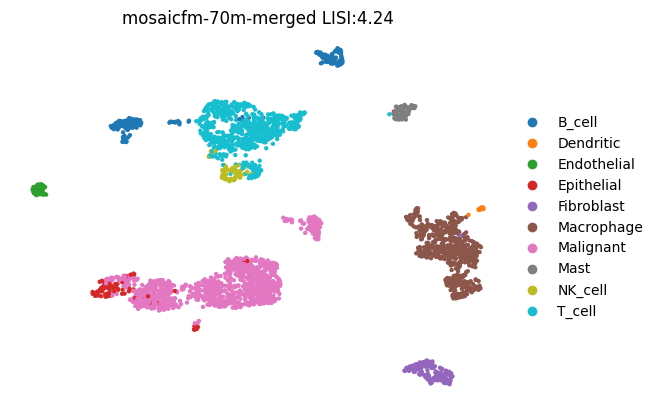

In [12]:
# Calculate LISI

cell_type_key = cfg.data.cell_type_key
lisi_score = compute_lisi_scores(cell_array, 
                                adata.obs[cell_type_key].values, 
                                20) 
print(f"LISI score: {lisi_score:.4f}")


# Plotting
adata.obs[cell_type_key] = adata.obs[cell_type_key].astype('category')
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} LISI:{lisi_score:.2f}"],
           return_fig=True)

# Save figure
save_dir = cfg.plot.save_dir
os.makedirs(save_dir, exist_ok=True)
fig.savefig(f"{save_dir}/{model_name}_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")

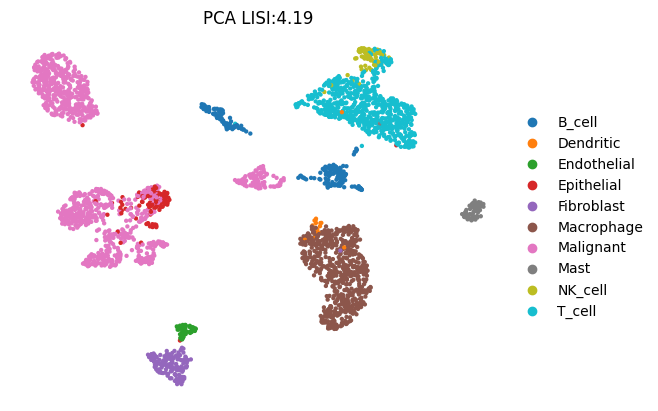

In [5]:
#PCA

sc.pp.normalize_total(adata, target_sum=10000, inplace=True)
sc.pp.log1p(adata)
sc.tl.pca(adata, n_comps=15)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

lisi_score = compute_lisi_scores(adata.obsm["X_pca"], adata.obs[cell_type_key], 20)
fig = sc.pl.umap(adata, color=cell_type_key, title=f"PCA LISI:{lisi_score:.2f}", return_fig=True, frameon=False,)

fig.savefig(f"{save_dir}/PCA_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")
